#Downloading Dataset

In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
from google.colab import files
files.upload()
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download wolfram77/graphs-snap-web
!unzip graphs-snap-web.zip -d graphs-snap-web

Saving kaggle.json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/wolfram77/graphs-snap-web
License(s): Attribution 4.0 International (CC BY 4.0)
graphs-snap-web.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  graphs-snap-web.zip
replace graphs-snap-web/web-BerkStan.mtx? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace graphs-snap-web/web-Google.mtx? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace graphs-snap-web/web-NotreDame.mtx? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace graphs-snap-web/web-Stanford.mtx? [y]es, [n]o, [A]ll, [N]one, [r]ename: no


#List Directory Contents

In [ ]:
import os

os.listdir('graphs-snap-web')


['web-Google.mtx', 'web-Stanford.mtx', 'web-NotreDame.mtx', 'web-BerkStan.mtx']

#Read and Process Sparse Matrix

In [ ]:
import numpy as np
from scipy.io import mmread

file_path = "graphs-snap-web/web-BerkStan.mtx"
adj_matrix = mmread(file_path).tocsc()
adj_matrix = adj_matrix[:subset_size, :subset_size]

#   Compute Transition Probability Matrix

In [ ]:
import numpy as np

def compute_transition_matrix(adj_mat):
    outgoing_links = np.array(adj_mat.sum(axis=0)).flatten()
    outgoing_links[outgoing_links == 0] = 1
    T = adj_mat.copy().astype(float)
    for col in range(T.shape[1]):
        T[:, col] /= outgoing_links[col]
    return T

transition_mat = compute_transition_matrix(adj_matrix)

#Adjust Dead Ends in Transition Matrix
# (Dangling Nodes)

In [ ]:
def adjust_dead_ends(transition_mat):

    num_pages = transition_mat.shape[0]
    dead_ends = np.where(transition_mat.sum(axis=0) == 0)[1]

    for col in dead_ends:
        transition_mat[:, col] = 1 / num_pages

    return transition_mat

adjusted_mat = adjust_dead_ends(transition_mat)




/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


# Generate PageRank Matrix

In [ ]:
def generate_rank_matrix(transition_mat, damping_factor=0.7):

    num_nodes = transition_mat.shape[0]
    uniform_matrix = np.ones((num_nodes, num_nodes)) / num_nodes
    rank_matrix = damping_factor * transition_mat + (1 - damping_factor) * uniform_matrix
    return rank_matrix

final_rank_matrix = generate_rank_matrix(adjusted_mat)


Calculate Eigenvector of a Matrix Using numpy.linalg

In [ ]:
import numpy as np

def calculate_rank_eigen(rank_matrix):

    eigen_vals, eigen_vecs = np.linalg.eig(rank_matrix)

    principal_idx = np.argmin(np.abs(eigen_vals - 1))
    rank_scores = np.real(eigen_vecs[:, principal_idx])
    rank_scores /= np.sum(rank_scores)

    return rank_scores

eigen_pagerank = calculate_rank_eigen(final_rank_matrix)
eigen_pagerank = np.array(eigen_pagerank).flatten()
top_20_nodes = np.argsort(-eigen_pagerank)[:20]
print("Top 20 pages by PageRank (First Method):", top_20_nodes)




Top 20 pages by PageRank (First Method): [509 860 612 692 702 371 564 459 256 425 295 717 329 741 197 699 232 160
 909 812]


#Calculate PageRank Using Power Iteration Method

In [ ]:

def power_iteration_pagerank(rank_matrix, max_steps=100, tolerance=1e-6):

    rank_matrix = np.array(rank_matrix)
    num_nodes = rank_matrix.shape[0]
    rank_vector = np.ones(num_nodes) / num_nodes

    for _ in range(max_steps):

        updated_rank = rank_matrix @ rank_vector
        updated_rank /= np.sum(updated_rank)
        if np.linalg.norm(updated_rank - rank_vector, 1) < tolerance:
            break

        rank_vector = updated_rank

    return rank_vector

iterative_pagerank = power_iteration_pagerank(final_rank_matrix)
top_20_nodes_power = np.argsort(-iterative_pagerank)[:20]
print("Top 20 pages by PageRank (Power Iteration):", top_20_nodes_power)




Top 20 pages by PageRank (Power Iteration): [509 860 612 692 702 371 564 459 256 425 295 717 329 741 197 699 232 160
 909 812]


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


#Implement PageRank Using NetworkX

#Create Directed Graph and Compute PageRank Using NetworkX

In [ ]:
import networkx as nx
import numpy as np

def calculate_pagerank_graph(adj_mat, damping_factor=0.7):

    graph = nx.DiGraph()
    src_nodes, dst_nodes = adj_mat.nonzero()
    graph_edges = list(zip(dst_nodes, src_nodes))
    graph.add_edges_from(graph_edges)

    rank_scores = nx.pagerank(graph, alpha=damping_factor)

    return rank_scores

    graph_pagerank = calculate_pagerank_graph(adj_matrix)
    rank_values = np.array(list(graph_pagerank.values()))
    top_20_nodes_nx = np.argsort(-rank_values)[:20]




#Compare Methods

In [ ]:
print("Top 20 pages by PageRank (First Method):", top_20_nodes)
print("Top 20 pages by Power Iteration:", top_20_nodes_power)
print("Top 20 pages by NetworkX:", top_20_nodes_nx)



Top 20 pages by PageRank (First Method): [509 860 612 692 702 371 564 459 256 425 295 717 329 741 197 699 232 160
 909 812]
Top 20 pages by Power Iteration: [509 860 612 692 702 371 564 459 256 425 295 717 329 741 197 699 232 160
 909 812]
Top 20 pages by NetworkX: [526 823 627 680  56 385 583 477 268 438 311  58 349 746 199 128 237 166
 890 821]


#Compare Power Iteration and NetworkX PageRank Methods

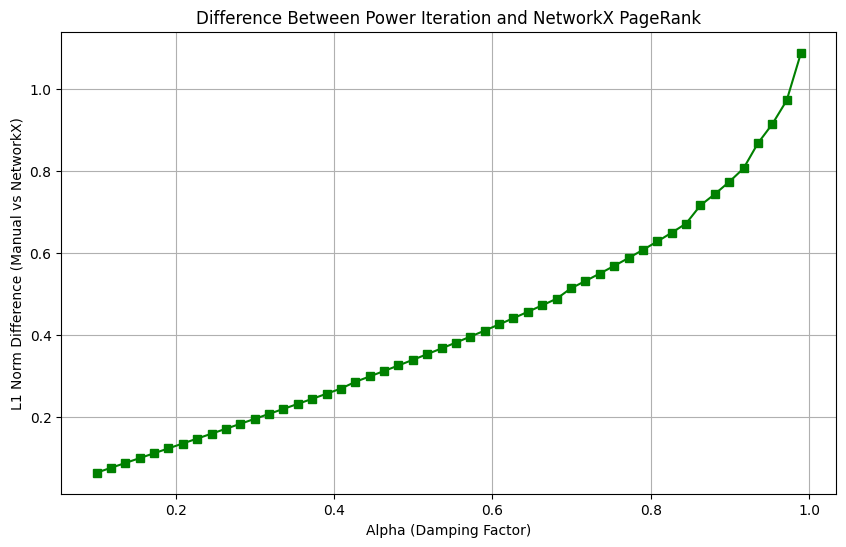

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import mmread
from scipy.sparse import csc_matrix

file_path = "graphs-snap-web/web-BerkStan.mtx"
adj_matrix = mmread(file_path).tocsc()
small_matrix = adj_matrix[:1000, :1000].copy()

G = nx.from_scipy_sparse_array(small_matrix, create_using=nx.DiGraph)

def pagerank_power_iteration(G, alpha=0.7, tol=1e-6, max_iter=100):
    nodes = list(G.nodes())
    N = len(nodes)
    M = nx.to_scipy_sparse_array(G, nodelist=nodes, dtype=float, format="csr")

    column_sums = np.array(M.sum(axis=0)).flatten()
    column_sums[column_sums == 0] = 1
    M = M.multiply(1 / column_sums)

    v = np.ones(N) / N
    teleport = np.ones(N) / N

    for _ in range(max_iter):
        v_new = alpha * (M @ v) + (1 - alpha) * teleport
        if np.linalg.norm(v_new - v, 1) < tol:
            break
        v = v_new

    return {node: score for node, score in zip(nodes, v)}

alpha_values = np.linspace(0.1, 0.99, 50)
norm_diff_results = []

for alpha in alpha_values:
    pr_manual = pagerank_power_iteration(G, alpha)

    try:
        pr_nx = nx.pagerank(G, alpha=alpha, max_iter=500, tol=1e-4)
    except nx.PowerIterationFailedConvergence:
        print(f"Warning: NetworkX PageRank did not converge for alpha = {alpha}")
        continue

    manual_values = np.array(list(pr_manual.values()))
    nx_values = np.array([pr_nx[node] for node in G.nodes()])
    norm_diff = np.linalg.norm(manual_values - nx_values, ord=1)
    norm_diff_results.append(norm_diff)

plt.figure(figsize=(10, 6))
plt.plot(alpha_values[:len(norm_diff_results)], norm_diff_results, marker='s', color='g')
plt.xlabel("Alpha (Damping Factor)")
plt.ylabel("L1 Norm Difference (Manual vs NetworkX)")
plt.title("Difference Between Power Iteration and NetworkX PageRank")
plt.grid(True)
plt.show()
